### Necessary imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import importlib

import clustering, utilities, recs_preprocessing

importlib.reload(clustering)
importlib.reload(utilities)
importlib.reload(recs_preprocessing)

from utilities import KWH2BTU, BTU2KWH, SQF2SQM, SQM2SQF, THM2BTU, BTU2THM
from recs_preprocessing import Codebook, df_computed
from clustering import cluster_evaluation_subset, evaluate_gmm, evaluate_gmm_weighted, evaluate_lightgbm, cluster_subset

def energy_loads_features():
    categorical_columns = []
    continuous_columns = [
        'RC_equipment_power_density', 'RC_gas_power_density', 'RC_DHW_elec_power_density',
        'RC_DHW_gas_power_density', 'RC_lighting_power_density']
    return categorical_columns, continuous_columns

def construction_features():
    categorical_columns = [
        'CELLAR', 'CRAWL', 'CONCRETE', 'BASEOTH', 'BASEFIN', 'ATTIC',
        'ATTICFIN', 'WALLTYPE', 'ROOFTYPE', 'ADQINSUL', 'TYPEGLASS', 'WINFRAME']
    continuous_columns = [
        'eui_kwh_elec_thermal', 'eui_btu_ng_thermal', 'eui_btu_ofuel_thermal', 'window_per_sqm', 'door_per_sqm'
    ]
    return categorical_columns, continuous_columns

def systems_features():
    # systems
    categorical_columns = [
        'EQUIPM', 'FUELHEAT', 'BASEHEAT', 'GARGHEAT', 'ATTCHEAT', 'GEOHP',
        'AIRCOND', 'COOLAPT', 'ACEQUIPM_PUB', 'BASECOOL', 'ATTCCOOL', 'GARGCOOL', 'EQUIPAGE', 'ACEQUIPAGE'
    ] # systems -> heating and cooling system
    continuous_columns = [
        'eui_kwh_elec_sph', 'eui_btu_ng_sph', 'eui_btu_ofuel_sph',
        'eui_kwh_elec_col', 'eui_kwh_elec_latent'
    ]
    return categorical_columns, continuous_columns


### Mock creation of one clustering instance (with good GMM performance)

In [2]:
systems_features()

(['EQUIPM',
  'FUELHEAT',
  'BASEHEAT',
  'GARGHEAT',
  'ATTCHEAT',
  'GEOHP',
  'AIRCOND',
  'COOLAPT',
  'ACEQUIPM_PUB',
  'BASECOOL',
  'ATTCCOOL',
  'GARGCOOL',
  'EQUIPAGE',
  'ACEQUIPAGE'],
 ['eui_kwh_elec_sph',
  'eui_btu_ng_sph',
  'eui_btu_ofuel_sph',
  'eui_kwh_elec_col',
  'eui_kwh_elec_latent'])

weight      
                sum count
label                    
0      2.754905e+06   328
1      1.414584e+06   150
2      5.065985e+06   517
3      1.699849e+05    19

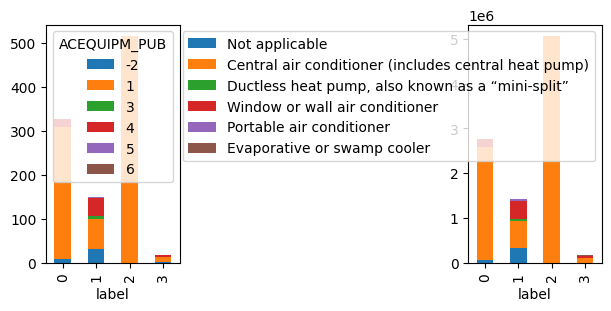

In [ ]:
from clustering import plot_cluster_result_bars, select_subset, cb
categorical_columns, continuous_columns = systems_features()
cat2 = 'ACEQUIPM_PUB'
cat1 = 'label'
subset_criteria = {'IECC_climate_code': '2A', 'TYPEHUQ': 2}
gmm, labels, _preprocessor, weights = cluster_subset(categorical_columns, continuous_columns, subset_criteria, 4, True)
pd.Series(labels).value_counts()

subset = select_subset(df_computed, by=subset_criteria)
test = subset[categorical_columns + continuous_columns + ['NWEIGHT']]
test['label'] = labels
grouped = test.groupby([cat1, cat2]).size().unstack(fill_value=0)
fig, axes = plt.subplots(1, 2, figsize=(6, 3), layout='constrained')
grouped.plot(kind='bar', stacked=True, ax=axes[0])
test.groupby([cat1, cat2])['NWEIGHT'].sum().unstack().fillna(0).plot(kind='bar', stacked=True, ax=axes[1])
axes[1].legend(cb.get_legend(cat2).set_index('code').loc[[str(c) for c in grouped.columns]]['description'],)

# summary of the count/total weight of samples within each cluster
summary = pd.DataFrame(
    {'weight': weights, 'label': labels}
).groupby('label').agg(['sum', 'count'])
summary

In [ ]:
excol = ['TOTSQFT_EN', 'TYPEHUQ', 'urban_grouped', 'acequipm_pub_grouped', 'FUELHEAT', 'EQUIPM', 'YEARMADERANGE', 'CELLAR', 'WALLTYPE', 'BASEFIN', 'num_u65', 'NUMADULT2',]

In [56]:
urban = subset[subset['urban_grouped'] == 0]
urban.groupby(by=[
    'FUELHEAT',
    'EQUIPM',
    'CELLAR',
    'WALLTYPE',
    'acequipm_pub_grouped'
    ]).size().unstack(fill_value=0)

acequipm_pub_grouped             0   1
FUELHEAT EQUIPM CELLAR WALLTYPE       
-2       -2     0      1         0   2
                       4         0   2
                       7         0   2
 1        3     0      1         1  17
                       2         0   2
                       3         1   2
                       4         0   3
                       6         0   2
          7     0      3         1   0
 2        3     0      1         0   1
                       3         0   2
                       6         0   2
          7     0      2         1   0
                       3         1   0
                       6         1   0
 5        3     0      1         0  26
                       2         1   4
                       3         1   8
                       4         0   9
                       5         0   1
                       6         0   1
                       7         0   2
          4     0      1         2  23
                       2         0  11
                       3         0  20
                       4         1  10
                       6         0   7
                       7         0   6
          5     0      1         0   1
                       2         0   1
                       3         1   2
                       4         0   1
          10    0      1         0   3
                       2         7   1
                       3         2   1
                       4         0   1
          13    0      1         0   1
                       2         1   0
          99    0      1         0   1
 7        8     0      2         0   1

<Figure size 500x500 with 0 Axes>

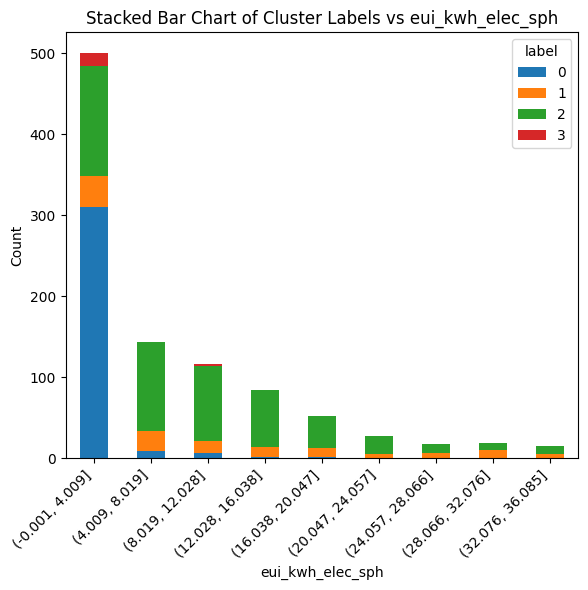

<Figure size 500x500 with 0 Axes>

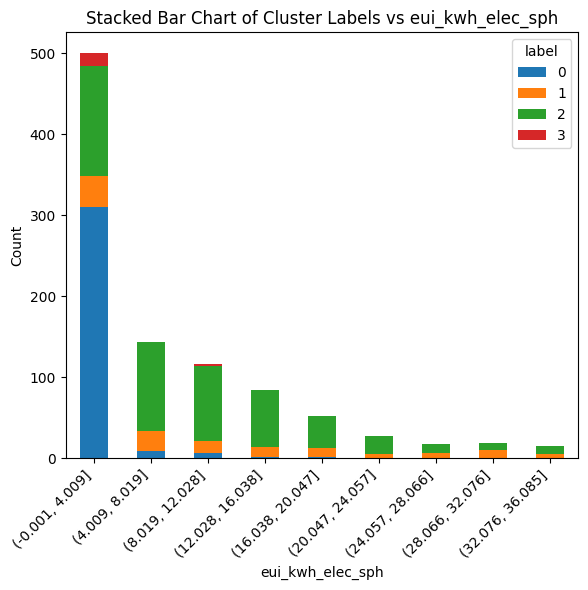

In [30]:
from clustering import categorical_numeric_bar
import seaborn as sns

categorical_numeric_bar(
    test, 'label', 'eui_kwh_elec_sph'
)

numeric = 'eui_kwh_elec_sph'
categorical = 'label'
df_plot = test.copy()

# Filter numeric data to remove outliers (values > 97th quantile)
q97 = df_plot[numeric].quantile(0.97)
filtered_df = df_plot[df_plot[numeric] <= q97]

# Define custom bin intervals
custom_bins = np.arange(0, q97, q97 / 10)  # Bins from 0 to 100 with intervals of 5
filtered_df['bin'] = pd.cut(filtered_df[numeric], bins=custom_bins, include_lowest=True)

# Group by bins and categorical feature
grouped = filtered_df.groupby(['bin', categorical]).size().unstack(fill_value=0)

# Plot the stacked bar chart
plt.figure(figsize=(5, 5), layout='tight')
grouped.plot(kind='bar', stacked=True, figsize=(6, 6),)

plt.title('Stacked Bar Chart of Cluster Labels vs {}'.format(numeric))
plt.xlabel(numeric)
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

(<Figure size 500x500 with 1 Axes>,
 <Axes: title={'center': 'eui_kwh_elec_sph by cluster label'}, xlabel='eui_kwh_elec_sph', ylabel='Density'>)

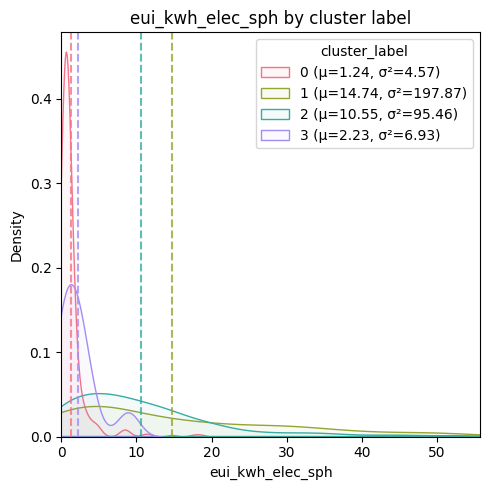

In [31]:
from clustering import continuous_feature_kde

continuous_feature_kde(test, 'eui_kwh_elec_sph', labels=labels)